<a href="https://colab.research.google.com/github/charman2/lasso_hydro/blob/main/lasso_hydro_lithology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from scipy.optimize import minimize
import scipy
import multiprocessing as mp
import seaborn as sns
import matplotlib
import matplotlib.cm as cm

# import geopandas as gpd
import urllib
import datetime
import time
import warnings
import sklearn
from sklearn.metrics import r2_score


In [ ]:
!git clone https://www.github.com/daviddralle/lasso_hydro

fatal: destination path 'lasso_hydro' already exists and is not an empty directory.


In [ ]:

def a(t, alpha, v0):
	return alpha*v0*(1+t*v0)**(-1-alpha)
def fv(v,alpha,v0):
	return 1/(scipy.special.gamma(alpha)*v0)*np.exp(-v/v0)*(v/v0)**(alpha-1)

def get_rechargefit(x0,Q, positive=True):
	Q = np.hstack([np.zeros_like(Q), Q])
	t = np.arange(len(Q))
	A = a(t, x0[0], x0[1])
	# create toeplitz matrix
	# performs convolution of IUH on input vector
	num_cols = len(Q)
	first_row = np.zeros(num_cols)
	first_row[0] = A[0]
	H = linalg.toeplitz(A, first_row)

	# validate over N folds  chosen at random indices
	N = 5
	traintest = []
	for i in range(N):
		frac = 1/N
		# only train/test over the second half of the dataset
		# allows for "spinup" to meet initial storage state
		idx1 = int(len(Q)/2)
		idx2 = len(Q)-1
		idx_train = np.random.choice(np.arange(idx1,idx2),int(len(Q)*frac), replace=False)
		idx_test = list(set(np.arange(idx1,len(Q))).difference(set(idx_train)))
		traintest.append((idx_train, idx_test))
	clf = linear_model.LassoCV(cv=traintest, positive=positive,max_iter=1000)
	clf.fit(H, Q)
	return clf, np.copy(H), np.copy(Q), t

def get_score(x0,Q, positive=True, logtransform=True):
	clf, H, Q, t = get_rechargefit(x0,Q,positive)
	rechargefit = clf.coef_
	Qfit = np.dot(H, rechargefit)
	idx = (Q>1e-10)&(Qfit>1e-10)
	Q = Q[idx]
	Qfit = Qfit[idx]
	if len(Qfit)==0:
		return 1e13
	else:
		if logtransform:
			return 1-r2_score(np.log(Q),np.log(Qfit))
		else:
			return 1-r2_score(Q,Qfit)

def getmin(args):
	f,x0,Q = args
	res = minimize(f, x0,method='Nelder-Mead', tol=1e-3, args = (Q))
	return res

In [ ]:
df = pd.read_csv('lasso_hydro/flow.csv', index_col=0)
sites = df.columns.values
# df.plot()

# Somewhat older code for fitting IUHs

In [ ]:

# ress = []
# for col in df.columns[-1:]:
#   print(col)
#   x0 = [0.5, 0.5]
#   Q = df[col].values
#   Q = Q[np.isfinite(Q)]
#   idx = np.min([len(Q), 2000])
#   Q = Q[-idx:]
#   num = mp.cpu_count()
#   p = mp.Pool(num)
#   args = [(get_score,[np.random.uniform(low=0.2,high=1.5), np.random.uniform(low=0.2,high=1.5)],Q) for i in range(num)]
#   res_candidates = p.map(getmin,args)
#   idx = np.argmin([item.fun for item in res_candidates])
#   res = res_candidates[idx]
#   ress.append(res)
#   break

# xs = [res.x for res in ress]
# tempdf = pd.DataFrame(xs)
# tempdf.index = df.columns
# tempdf.to_csv('ress.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Text(0.5, 0, 'V [1/days]')

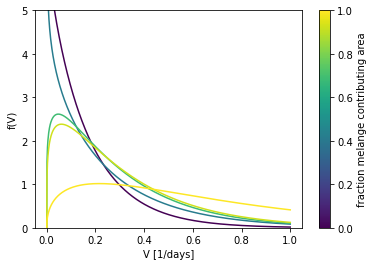

In [ ]:

ress = pd.read_csv('./lasso_hydro/ress.csv',dtype={0:str})
ress.columns = ['gage','alpha','v0']
ress = ress.set_index('gage')
lith = pd.read_pickle('./lasso_hydro/lith.p')
ress['cv'] = ress['alpha']**(-0.5)
ress['avg'] = ress['alpha']*ress['v0']
ress['sd'] = ress['cv']*ress['avg']
temp = pd.DataFrame({'melange':[1]}, index=['00000000'])
lith = lith.append(temp)
master = lith.merge(ress, right_index=True, left_index=True)

minima = min(master.melange)
maxima = max(master.melange)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')

master = master.sort_values('melange')
for i,row in master.iterrows():
  v = np.linspace(0,1,1000)
  alpha = row.alpha
  v0 = row.v0
  pv = fv(v,alpha,v0)
  plt.plot(v,pv,c=mapper.to_rgba(row.melange))
plt.ylim(0,5)
cb = plt.colorbar(mapper)
cb.set_label('fraction melange contributing area')
plt.ylabel('f(V)')
plt.xlabel('V [1/days]')

# Use best params, fit, plot hydrographs and recharge sequences

In [ ]:
# scores = []
# for col in master.index.values:
#   print(col)
#   Q = df[col].values
#   Q = Q[np.isfinite(Q)]
#   idx = np.min([len(Q), 1000])
#   Q = Q[-idx:]
#   x0 = master.loc[col][['alpha','v0']].values
#   clf, H, Q, t = get_rechargefit(x0,Q,True)
#   rechargefit = clf.coef_
#   Qfit = np.dot(H, rechargefit)
#   f,axs = plt.subplots(2,1,figsize=(6,3.5),sharex=True)
#   ax = axs[0]
#   ax.plot(Q)
#   ax.plot(Qfit)
#   axs[1].plot(rechargefit)
#   ax.set_yscale('log')
#   ax.set_title(col)
#   ax.set_xlim([1500,2000])


0.9642793211721041


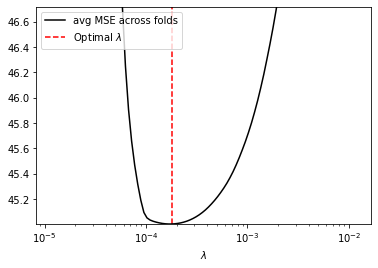

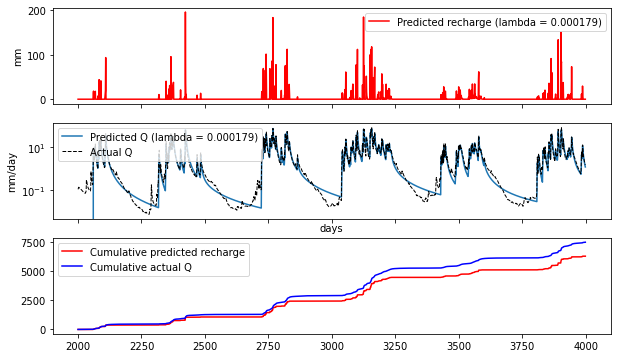

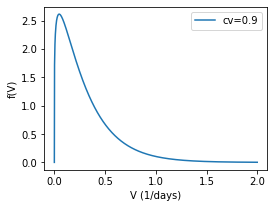

In [ ]:
# specify gauge id
idx = '11478500'

x0 = ress.loc[idx].values
cv = x0[0]**(-0.5)
Q = df[idx].values
Q = Q[np.isfinite(Q)]
Q = Q[-2000:]

clf, H, Qtemp, t = get_rechargefit(x0,Q,positive=True)
rechargefit = clf.coef_
Qfit = np.dot(H, rechargefit)

idxstart = int(len(Qfit)/2)
Qfit = Qfit[idxstart:]
Qtemp = Qtemp[idxstart:]
rechargefit = rechargefit[idxstart:]
t = t[idxstart:]

f,ax = plt.subplots(1)
ax.semilogx(clf.alphas_,np.mean(clf.mse_path_,axis=1),c='k',label='avg MSE across folds')
minval = np.min(np.mean(clf.mse_path_,axis=1))
maxval = np.max(np.mean(clf.mse_path_,axis=1))
ax.vlines(clf.alpha_, minval, maxval,colors='r',ls='--', label=r'Optimal $\lambda$')
ax.legend()
vals = np.mean(clf.mse_path_,axis=1)
vals = np.sort(vals)
ax.set_ylim([vals[0],vals[int(len(vals)/2)]])
ax.set_xlabel(r'$\lambda$')

print(r2_score(Qtemp,Qfit))
f,axs = plt.subplots(3,1,figsize=(10,6),sharex=True)
ax = axs[0]
ax.plot(t,rechargefit, label='Predicted recharge (lambda = %f)'%clf.alpha_,c='r')
# ax.plot(t,rain,label='Rainfall',lw=1,c='k',ls='--')
ax.set_ylabel('mm')
# ax.set_yscale('log')
ax.legend()

ax = axs[1]
ax.plot(t,Qfit, label='Predicted Q (lambda = %f)'%clf.alpha_)
ax.plot(t,Qtemp,label='Actual Q',lw=1,c='k',ls='--')
ax.set_xlabel('days')
ax.set_ylabel('mm/day')
ax.set_yscale('log')
ax.legend()

ax = axs[2]
ax.plot(t,np.cumsum(rechargefit), label='Cumulative predicted recharge'%clf.alpha_,c='r')
ax.plot(t,np.cumsum(Qtemp), label='Cumulative actual Q'%clf.alpha_,c='b')
ax.legend()

f,ax = plt.subplots(1,figsize=(4,3))
v = np.linspace(0,2,1000)
pv = fv(v,x0[0],x0[1])
ax.plot(v,pv,label='cv=%.1f'%cv)
ax.set_xlabel('V (1/days)')
ax.set_ylabel('f(V)')
ax.legend()

Text(0.5, 0, 'Fraction melange')

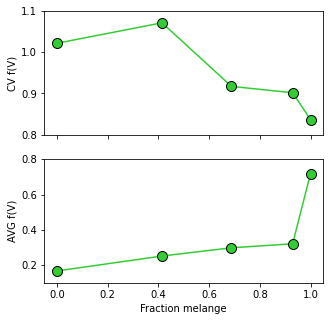

In [ ]:
# plt.scatter(master.melange, master.cv,c='limegreen',ec='k',s=100)
f,axs = plt.subplots(2,1,figsize=(5,5),sharex=True)
ax = axs[0]
ax.plot(master.melange, master.cv,c='limegreen')
ax.scatter(master.melange, master.cv,c='limegreen',ec='k',s=100,zorder=4)
ax.set_ylim([0.8,1.1])
ax.set_ylabel('CV f(V)')
ax = axs[1]
ax.plot(master.melange, master.avg,c='limegreen')
ax.scatter(master.melange, master.avg,c='limegreen',ec='k',s=100,zorder=4)
ax.set_ylim([0.1,0.8])
ax.set_ylabel('AVG f(V)')
ax.set_xlabel('Fraction melange')

